In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset**

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Dataset/artists.csv')

# Group the data by artist name and collect paintings into a list
grouped = df.groupby('name')['paintings'].apply(list)

# Print each artist with an enumeration and their list of paintings
for index, (artist, paintings) in enumerate(grouped.items(), 1):
    print(f"{index}. {artist}")

1. Albrecht Dürer
2. Alfred Sisley
3. Amedeo Modigliani
4. Andrei Rublev
5. Andy Warhol
6. Camille Pissarro
7. Caravaggio
8. Claude Monet
9. Diego Rivera
10. Diego Velazquez
11. Edgar Degas
12. Edouard Manet
13. Edvard Munch
14. El Greco
15. Eugene Delacroix
16. Francisco Goya
17. Frida Kahlo
18. Georges Seurat
19. Giotto di Bondone
20. Gustav Klimt
21. Gustave Courbet
22. Henri Matisse
23. Henri Rousseau
24. Henri de Toulouse-Lautrec
25. Hieronymus Bosch
26. Jackson Pollock
27. Jan van Eyck
28. Joan Miro
29. Kazimir Malevich
30. Leonardo da Vinci
31. Marc Chagall
32. Michelangelo
33. Mikhail Vrubel
34. Pablo Picasso
35. Paul Cezanne
36. Paul Gauguin
37. Paul Klee
38. Peter Paul Rubens
39. Pierre-Auguste Renoir
40. Piet Mondrian
41. Pieter Bruegel
42. Raphael
43. Rembrandt
44. Rene Magritte
45. Salvador Dali
46. Sandro Botticelli
47. Titian
48. Vasiliy Kandinskiy
49. Vincent van Gogh
50. William Turner


In [ ]:
content_path = '/content/miasto.jpg'

artist_number = 49

In [ ]:
import random

# Retrieve selected artist's data
selected_artist = grouped.iloc[artist_number - 1]

# Randomly choose a painting from the selected artist's list
painting_count = selected_artist[0]
random_index = 63 #specific painting, random below
#random.randint(0, painting_count - 1)  # Adjusted to start index from 0

# Get the artist's name from the index of the grouped Series
artist_name = "_".join(grouped.index[artist_number - 1].split())
style_path = "/content/gowno.jpeg"
# style_path = f'/content/drive/MyDrive/Dataset/resized/{artist_name}_{149}.jpg'

print(f"Selected Painting Path: {style_path}")

Selected Painting Path: /content/gowno.jpeg


In [ ]:
#!unzip /content/drive/MyDrive/Dataset/resized.zip -d /content/drive/MyDrive/Dataset

Archive:  /content/drive/MyDrive/Dataset/resized.zip
replace /content/drive/MyDrive/Dataset/resized/Marc_Chagall_136.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Libraries**

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time
import functools

**Functions**

In [ ]:
# This function converts a tensor representing an image to a PIL Image object, ensuring proper scaling and data type conversion.
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
# This function loads an image from the specified path, resizes it to fit within a maximum dimension while maintaining aspect ratio, converts it to a float32 tensor, and adds a batch dimension.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
# This function displays an image using matplotlib, optionally adding a title, and handles batched images by removing the batch dimension before displaying.
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

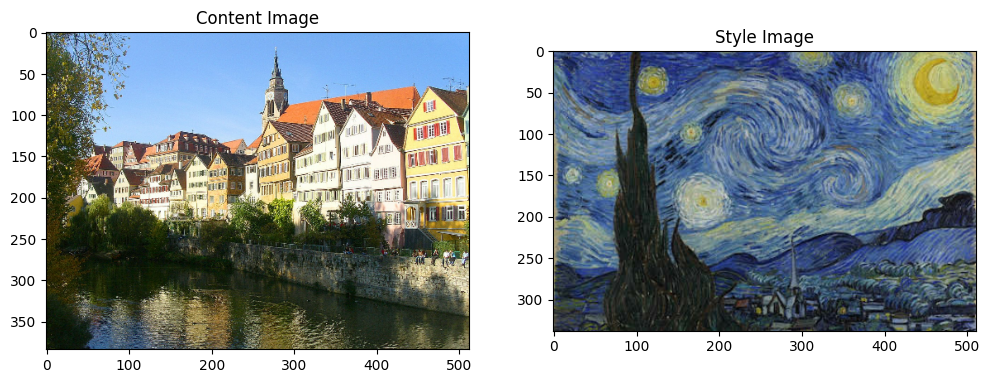

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

**Definition of the model**

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
# Content_layers specifies the layer for content representation and style_layers specifies the layers for style representation
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

**Function for style calculation**

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

**Extraction of style and content**

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
#instance of the StyleContentModel class with the specified style_layers and content_layers, extraction of style and content representations. The results variable contains dictionaries with the extracted content and style representations.
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e2
content_weight=1e8

**Loss function**

In [ ]:
# Function calculates the total style-content loss based on the extracted style and content representations and their respective targets.
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

**Model training**

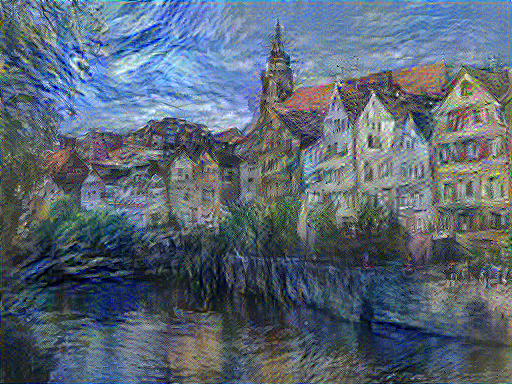

Train step: 1500


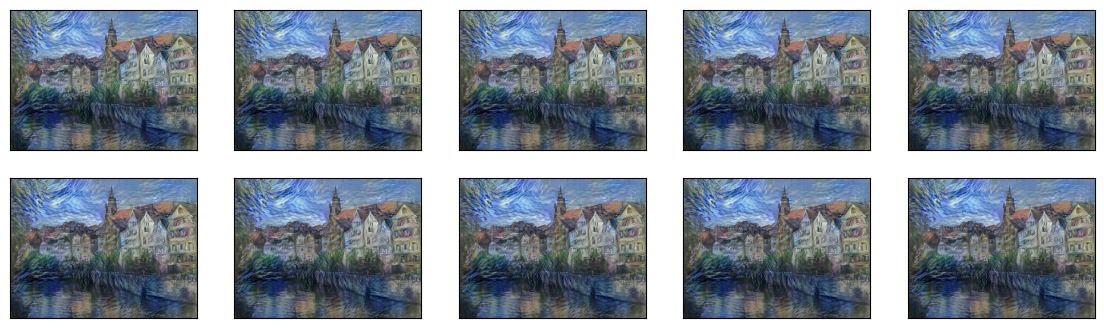

Total time: 106.1


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 150

images = []

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  images.append(tensor_to_image(image))

  print("Train step: {}".format(step))

# For displaying
num_rows = 2
num_cols = 5

# Plot all the images side by side
plt.figure(figsize=(14, 4))
for i, img in enumerate(images):
    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>